# Preprocessing of WOD18 data
    - Calculates potential density, N2 and MLD from discrete sample
    - L09 dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import sklearn as skl
import gsw
import cartopy.crs as ccrs
from scipy.interpolate import interp1d

### First prepare O2, T, S, stratification data from WOD

In [ ]:
# observational data 
diro = '/glade/scratch/ito/WOD18_OSDCTD/'
fosd='_1x1bin_osd_'
fctd='_1x1bin_ctd_'
var=['t','s','o2']

In [ ]:
# basin mask
dsm=xr.open_dataset('/glade/work/ito/dataset/model/basin_mask_01.nc')

In [ ]:
# first calculate potential density and stratification
def calc_potdens(year):
    #
    N21 = np.zeros((12,47,180,360))*np.nan
    N20 = np.zeros((12,46,180,360))*np.nan
    MLD_125 = np.zeros((12,180,360))*np.nan
    MLD_030 = np.zeros((12,180,360))*np.nan
    z1=np.zeros(46,)
    #
    dt=xr.open_dataset(diro+var[0]+fosd+str(year)+'.nc')
    ds=xr.open_dataset(diro+var[1]+fosd+str(year)+'.nc')
    SA = gsw.SA_from_SP(ds.s,ds.depth,ds.lon,ds.lat)
    CT = gsw.CT_from_pt(SA,dt.t)
    sig0 = gsw.sigma0(SA,CT)
    z=ds.depth.to_numpy()
    Nz=np.size(z)
    sig0=sig0.to_numpy()
    #
    for k in range(Nz-1):
        N20[:,k,:,:]=9.8/1025*(sig0[:,k,:,:]-sig0[:,k+1,:,:])/(z[k]-z[k+1])
        z1[k]=.5*(z[k]+z[k+1])
    #
    for nx in range(360):
        #if nx%10==0:
        #    print(nx)
        for ny in range(180):
            for nm in range(12):
                sigsfc=np.nansum(sig0[nm,:,ny,nx])
                if np.isnan(sigsfc)==False:
                    n21 = interp1d(z1,N20[nm,:,ny,nx],'linear',bounds_error=False,fill_value=np.nan)
                    N21[nm,:,ny,nx]=n21(z)
                    mld0 = interp1d(sig0[nm,:,ny,nx],z,'linear',bounds_error=False,fill_value=np.nan)
                    MLD_125[nm,ny,nx]=mld0(sig0[nm,0,ny,nx]+0.125)
                    MLD_030[nm,ny,nx]=mld0(sig0[nm,0,ny,nx]+0.030)
    N21[:,0,:,:]=N21[:,1,:,:]
    # -------
    # write it out as a combined netCDF file
    da = xr.DataArray(data=sig0,name='sigma0',dims=['mon','depth','lat','lon'],
                           coords={'mon':ds.mon,'depth':ds.depth,'lat':ds.lat,'lon':ds.lon})
    dd = da.to_dataset()
    dd['N2'] = xr.DataArray(data=N21,name='N2',dims=['mon','depth','lat','lon'],
                           coords={'mon':ds.mon,'depth':ds.depth,'lat':ds.lat,'lon':ds.lon})
    dd['MLD_125'] = xr.DataArray(data=MLD_125,name='MLD_125',dims=['mon','lat','lon'],
                           coords={'mon':ds.mon,'lat':ds.lat,'lon':ds.lon})
    dd['MLD_030'] = xr.DataArray(data=MLD_030,name='MLD_030',dims=['mon','lat','lon'],
                           coords={'mon':ds.mon,'lat':ds.lat,'lon':ds.lon})
    dd['SA'] = SA
    dd['CT'] = CT
    dd.to_netcdf(diro+'TSN2'+fosd+str(year)+'.nc')
    return 1

In [ ]:
yrs=np.arange(1965,2021,1)
from multiprocessing import Pool
if __name__ == '__main__':
    with Pool(8) as p:
        print(p.map(calc_potdens, yrs))

In [ ]:
# first calculate potential density and stratification
def calc_potdens_ctd(year):
    #
    N21 = np.zeros((12,47,180,360))*np.nan
    N20 = np.zeros((12,46,180,360))*np.nan
    MLD_125 = np.zeros((12,180,360))*np.nan
    MLD_030 = np.zeros((12,180,360))*np.nan
    z1=np.zeros(46,)
    #
    dt=xr.open_dataset(diro+var[0]+fctd+str(year)+'.nc')
    ds=xr.open_dataset(diro+var[1]+fctd+str(year)+'.nc')
    SA = gsw.SA_from_SP(ds.s,ds.depth,ds.lon,ds.lat)
    CT = gsw.CT_from_pt(SA,dt.t)
    sig0 = gsw.sigma0(SA,CT)
    z=ds.depth.to_numpy()
    Nz=np.size(z)
    sig0=sig0.to_numpy()
    #
    for k in range(Nz-1):
        N20[:,k,:,:]=9.8/1025*(sig0[:,k,:,:]-sig0[:,k+1,:,:])/(z[k]-z[k+1])
        z1[k]=.5*(z[k]+z[k+1])
    #
    for nx in range(360):
        #if nx%10==0:
        #    print(nx)
        for ny in range(180):
            for nm in range(12):
                sigsfc=np.nansum(sig0[nm,:,ny,nx])
                if np.isnan(sigsfc)==False:
                    n21 = interp1d(z1,N20[nm,:,ny,nx],'linear',bounds_error=False,fill_value=np.nan)
                    N21[nm,:,ny,nx]=n21(z)
                    mld0 = interp1d(sig0[nm,:,ny,nx],z,'linear',bounds_error=False,fill_value=np.nan)
                    MLD_125[nm,ny,nx]=mld0(sig0[nm,0,ny,nx]+0.125)
                    MLD_030[nm,ny,nx]=mld0(sig0[nm,0,ny,nx]+0.030)
    N21[:,0,:,:]=N21[:,1,:,:]
    # -------
    # write it out as a combined netCDF file
    da = xr.DataArray(data=sig0,name='sigma0',dims=['mon','depth','lat','lon'],
                           coords={'mon':ds.mon,'depth':ds.depth,'lat':ds.lat,'lon':ds.lon})
    dd = da.to_dataset()
    dd['N2'] = xr.DataArray(data=N21,name='N2',dims=['mon','depth','lat','lon'],
                           coords={'mon':ds.mon,'depth':ds.depth,'lat':ds.lat,'lon':ds.lon})
    dd['MLD_125'] = xr.DataArray(data=MLD_125,name='MLD_125',dims=['mon','lat','lon'],
                           coords={'mon':ds.mon,'lat':ds.lat,'lon':ds.lon})
    dd['MLD_030'] = xr.DataArray(data=MLD_030,name='MLD_030',dims=['mon','lat','lon'],
                           coords={'mon':ds.mon,'lat':ds.lat,'lon':ds.lon})
    dd['SA'] = SA
    dd['CT'] = CT
    dd.to_netcdf(diro+'TSN2'+fctd+str(year)+'.nc')
    return 1

In [ ]:
yrs=np.arange(1987,2021,1)
from multiprocessing import Pool
if __name__ == '__main__':
    with Pool(8) as p:
        print(p.map(calc_potdens_ctd, yrs))

# Prepare the gridded T, S, N2 data

In [2]:
#diro='/glade/campaign/univ/ugit0034/EN4/EN4.2.1_l09/'
diro='/glade/scratch/ito/EN4/EN4.2.1_l09/'
fno='EN.4.2.1.f.analysis.l09.'
suff='L09'
mon=["%.2d" % i for i in np.arange(1,13,1)]
yrs=np.arange(1965,2019,1)

In [4]:
#ds=xr.open_dataset(diro+'EN4_TSN2_L09_196501_temp.nc')
#ds.sigma0[0,0,:,:].plot()

In [ ]:
def calc_N2_EN4(year):
    for mn in range(12):
        ds=xr.open_dataset(diro+fno+str(year)+mon[mn]+'.nc')
        time=np.array([str(year)+'-'+mon[mn]],dtype='datetime64[M]')
        t = ds.temperature - 273.15
        s = ds.salinity
        x0=ds.lon.to_numpy()
        Nx=np.size(x0)
        y0=ds.lat.to_numpy()
        Ny=np.size(y0)
        z0=ds.depth.to_numpy()
        Nz=np.size(z0)
        #
        sa= gsw.SA_from_SP(s,ds.depth,ds.lon,ds.lat)
        ct= gsw.CT_from_t(sa,t,ds.depth)
        sig0=gsw.sigma0(sa,ct)
        N20=np.zeros((1,Nz-1,Ny,Nx))
        N21=np.zeros((1,Nz,Ny,Nx))
        MLD_125=np.zeros((1,Ny,Nx))
        MLD_030=np.zeros((1,Ny,Nx))
        z1=np.zeros(Nz-1,)
        sig0=sig0.to_numpy()
        #
        for k in range(Nz-1):
            N20[0,k,:,:]=9.8/1025*(sig0[:,k,:,:]-sig0[:,k+1,:,:])/(z0[k]-z0[k+1])
            z1[k]=.5*(z0[k]+z0[k+1])
        #
        for nx in range(Nx):
            #if nx%10==0:
            #    print(nx)
            for ny in range(Ny):
                sigsfc=np.nansum(sig0[0,:,ny,nx])
                if np.isnan(sigsfc)==False:
                    n21 = interp1d(z1,N20[0,:,ny,nx],'linear',bounds_error=False,fill_value=np.nan)
                    N21[0,:,ny,nx]=n21(z0)
                    mld0 = interp1d(sig0[0,:,ny,nx],z0,'linear',bounds_error=False,fill_value=np.nan)
                    MLD_125[0,ny,nx]=mld0(sig0[0,0,ny,nx]+0.125)
                    MLD_030[0,ny,nx]=mld0(sig0[0,0,ny,nx]+0.030)
        N21[:,0,:,:]=N21[:,1,:,:]
        # -------
        # write it out as a combined netCDF file
        da = xr.DataArray(data=sig0,name='sigma0',dims=['time','depth','lat','lon'],
                           coords={'time':time,'depth':ds.depth,'lat':ds.lat,'lon':ds.lon})
        dd = da.to_dataset()
        dd['N2'] = xr.DataArray(data=N21,name='N2',dims=['time','depth','lat','lon'],
                           coords={'time':time,'depth':ds.depth,'lat':ds.lat,'lon':ds.lon})
        dd['MLD_125'] = xr.DataArray(data=MLD_125,name='MLD_125',dims=['time','lat','lon'],
                           coords={'time':time,'lat':ds.lat,'lon':ds.lon})
        dd['MLD_030'] = xr.DataArray(data=MLD_030,name='MLD_030',dims=['time','lat','lon'],
                           coords={'time':time,'lat':ds.lat,'lon':ds.lon})
        dd['SA'] = xr.DataArray(data=sa.to_numpy(),name='SA',dims=['time','depth','lat','lon'],
                           coords={'time':time,'depth':ds.depth,'lat':ds.lat,'lon':ds.lon})
        dd['CT'] = xr.DataArray(data=ct.to_numpy(),name='CT',dims=['time','depth','lat','lon'],
                           coords={'time':time,'depth':ds.depth,'lat':ds.lat,'lon':ds.lon})
        dd.to_netcdf(diro+'EN4_TSN2_'+suff+'_'+str(year)+mon[mn]+'.nc')
    return 1

In [ ]:
yrs=np.arange(1965,2019,1)
from multiprocessing import Pool
if __name__ == '__main__':
    with Pool(10) as p:
        print(p.map(calc_N2_EN4, yrs))

array([5.000e+00, 1.500e+01, 2.500e+01, 3.500e+01, 4.500e+01, 5.600e+01,
       6.600e+01, 7.700e+01, 8.700e+01, 9.800e+01, 1.100e+02, 1.220e+02,
       1.350e+02, 1.490e+02, 1.660e+02, 1.850e+02, 2.070e+02, 2.350e+02,
       2.710e+02, 3.150e+02, 3.730e+02, 4.470e+02, 5.410e+02, 6.570e+02,
       8.000e+02, 9.680e+02, 1.162e+03, 1.379e+03, 1.615e+03, 1.868e+03,
       2.134e+03, 2.409e+03, 2.691e+03, 2.978e+03, 3.269e+03, 3.563e+03,
       3.859e+03, 4.156e+03, 4.454e+03, 4.752e+03, 5.051e+03, 5.350e+03],
      dtype=float32)

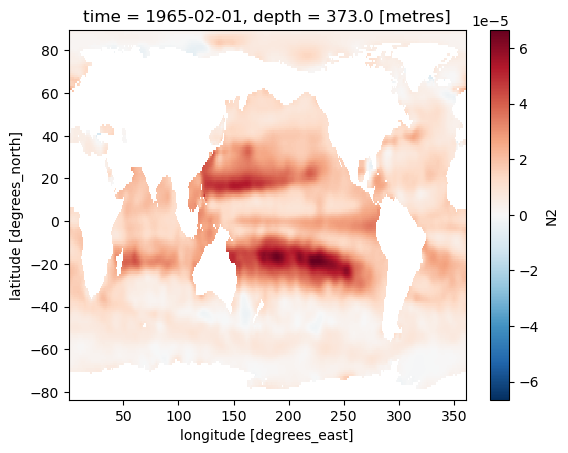

In [10]:
ds=xr.open_dataset(diro+'EN4_TSN2_L09_'+str(1965)+'02.nc')
ds.N2[0,20,:,:].plot()
np.round(ds.depth.to_numpy())

array([   6.,   10.,   20.,   30.,   40.,   50.,   65.,   80.,  100.,
        150.,  200.,  250.,  300.,  400.,  500.,  600.,  700.,  800.,
        900., 1000.], dtype=float32)

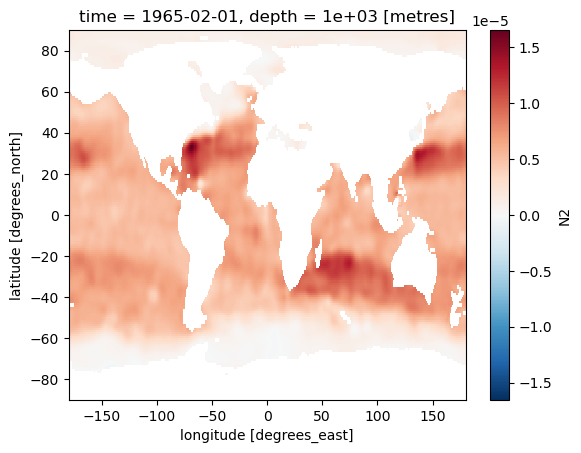

In [11]:
ds=xr.open_dataset(diro+'EN4_TSN2_L09_180x360_'+str(1965)+'02.nc')
ds.N2[0,19,:,:].plot()
np.round(ds.depth.to_numpy())